# 1. Install Dependencies

In [5]:
!pip install pycocotools
!pip install tensorflow


In [4]:
import os
import json
import pandas as pd
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pycocotools.coco import COCO
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [10]:
# Define file paths
ANNOTATION_FILE = 'annotation_subset/instances_train2017_subset.json'
IMAGE_FOLDER = 'train2017'
OUTPUT_FOLDER = 'processed_images'

# 2. Load COCO Annotations

In [8]:
coco = COCO(ANNOTATION_FILE)

loading annotations into memory...
Done (t=8.52s)
creating index...
index created!


#  Basic Dataset Overview
## (a) Check Total Images, Annotations, and Categories

In [10]:
print(f"Total Images: {len(coco.imgs)}")
print(f"Total Annotations: {len(coco.anns)}")
print(f"Total Categories: {len(coco.cats)}")


Total Images: 29571
Total Annotations: 212806
Total Categories: 80


## (b) List All Categories

In [12]:
categories = coco.loadCats(coco.getCatIds())
category_names = [cat['name'] for cat in categories]
print("Categories:", category_names)


Categories: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


## (c) Count Annotations per Category

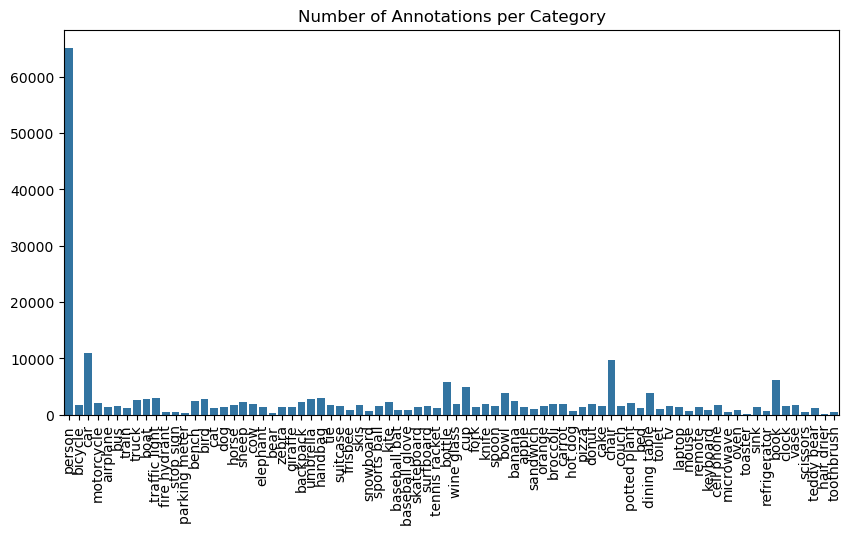

In [14]:
category_counts = {cat['name']: len(coco.getAnnIds(catIds=cat['id'])) for cat in categories}
plt.figure(figsize=(10,5))
sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.xticks(rotation=90)
plt.title("Number of Annotations per Category")
plt.show()


# 4. Visualizing Sample Images with Annotations
## (a) Load and Display a Random Image with Annotations

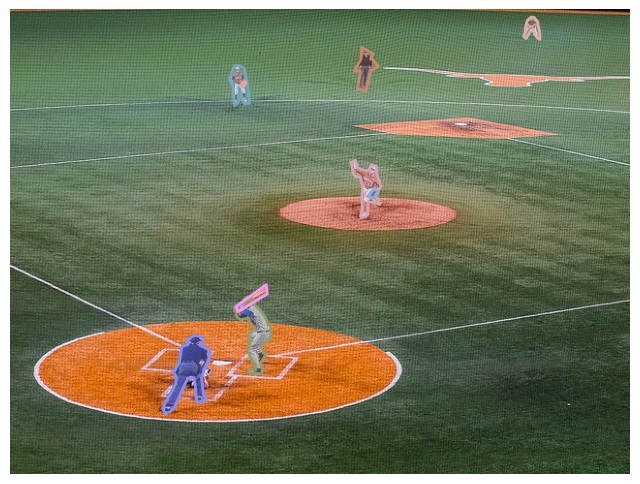

In [16]:
def show_image_with_annotations(image_id):
    image_info = coco.loadImgs([image_id])[0]  # Pass as a list
    image_path = os.path.join(IMAGE_FOLDER, image_info['file_name'])  # Fix file name key

    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get annotations
    ann_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(ann_ids)

    # Plot image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')

    # Overlay annotations
    coco.showAnns(annotations)
    plt.show()

# Show a random image
random_image_id = np.random.choice(list(coco.imgs.keys()))  # Ensure valid ID
show_image_with_annotations(random_image_id)


# 5. Distribution of Bounding Box Sizes

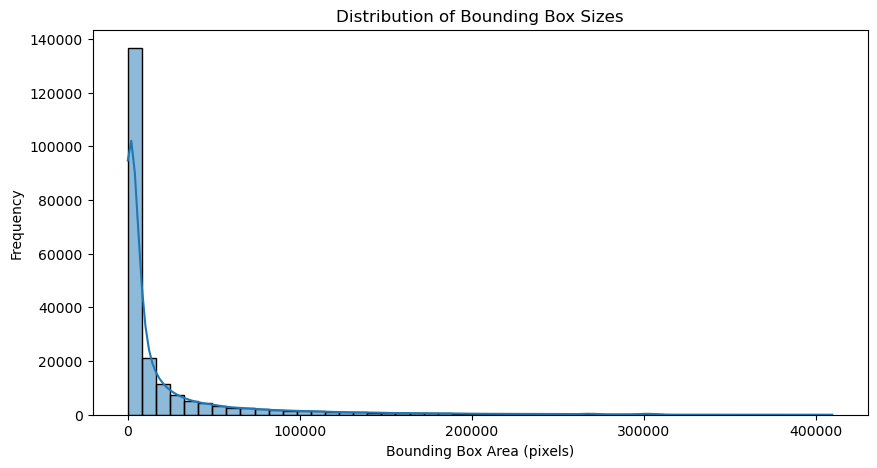

In [18]:
bbox_sizes = [ann['bbox'][2] * ann['bbox'][3] for ann in coco.anns.values()]
plt.figure(figsize=(10,5))
sns.histplot(bbox_sizes, bins=50, kde=True)
plt.xlabel("Bounding Box Area (pixels)")
plt.ylabel("Frequency")
plt.title("Distribution of Bounding Box Sizes")
plt.show()


# 6. Image-wise Annotation Count

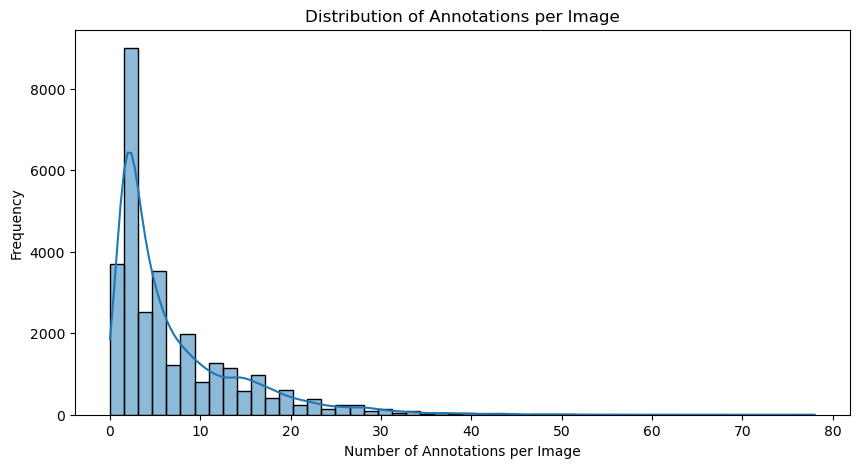

In [20]:
image_ann_counts = [len(coco.getAnnIds(imgIds=img_id)) for img_id in coco.imgs.keys()]
plt.figure(figsize=(10,5))
sns.histplot(image_ann_counts, bins=50, kde=True)
plt.xlabel("Number of Annotations per Image")
plt.ylabel("Frequency")
plt.title("Distribution of Annotations per Image")
plt.show()


# 7. Export EDA Results to JSON

In [22]:
eda_results = {
    "total_images": len(coco.imgs),
    "total_annotations": len(coco.anns),
    "total_categories": len(coco.cats),
    "category_distribution": category_counts,
}

# Save as JSON file
with open("coco_eda_results.json", "w") as f:
    json.dump(eda_results, f, indent=4)

print("EDA results saved to coco_eda_results.json")


EDA results saved to coco_eda_results.json


In [28]:
# Create output directory if it doesn't exist
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Load COCO dataset annotations
with open(ANNOTATION_FILE, 'r') as f:
    coco_data = json.load(f)

# Initialize COCO API
coco = COCO(ANNOTATION_FILE)

# Set target image size
IMG_SIZE = (256, 256)

# Process and resize images
for img_info in tqdm(coco_data['images'], desc="Processing Images"):
    img_id = img_info['id']
    file_name = img_info['file_name']
    img_path = os.path.join(IMAGE_FOLDER, file_name)

    # Check if file exists
    if not os.path.exists(img_path):
        print(f"Skipping {file_name}: File not found.")
        continue

    # Load image using OpenCV
    image = cv2.imread(img_path)
    
    # Convert from BGR (OpenCV default) to RGB (PIL format)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize image
    resized_img = cv2.resize(image, IMG_SIZE, interpolation=cv2.INTER_AREA)

    # Normalize pixel values (0-1)
    normalized_img = resized_img / 255.0

    # Convert back to uint8 for saving
    output_img = (normalized_img * 255).astype(np.uint8)

    # Save processed image using PIL
    output_path = os.path.join(OUTPUT_FOLDER, file_name)
    Image.fromarray(output_img).save(output_path)

print(f"Processing complete! Resized images are saved in '{OUTPUT_FOLDER}'.")

loading annotations into memory...
Done (t=6.64s)
creating index...
index created!


Processing Images: 100%|█████████████████████████████████████████████████████████| 29571/29571 [17:34<00:00, 28.03it/s]


Processing complete! Resized images are saved in 'processed_images'.


In [12]:
AUGMENTED_FOLDER = 'augmented_images'
os.makedirs(AUGMENTED_FOLDER, exist_ok=True)

# Define augmentation pipeline using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,           # Rotate image ±30°
    horizontal_flip=True,        # Flip horizontally
    brightness_range=[0.8, 1.2], # Adjust brightness
    zoom_range=0.2,              # Zoom in/out
    width_shift_range=0.2,       # Shift width
    height_shift_range=0.2,      # Shift height
    shear_range=0.2              # Shear transformation
)

# Process images
for file_name in tqdm(os.listdir(OUTPUT_FOLDER), desc="Augmenting Images"):
    img_path = os.path.join(OUTPUT_FOLDER, file_name)

    # Read image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Skipping {file_name}, unable to read.")
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Generate augmented images
    i = 0
    for batch in datagen.flow(image, batch_size=1):
        augmented_image = batch[0].astype(np.uint8)
        output_path = os.path.join(AUGMENTED_FOLDER, f"aug_{i}_{file_name}")
        Image.fromarray(augmented_image).save(output_path)
        i += 1
        if i >= 5:  # Generate 5 augmented versions per image
            break

print(f"Augmentation complete! Augmented images are saved in '{AUGMENTED_FOLDER}'.")

Augmenting Images: 100%|███████████████████████████████████████████████████████| 29571/29571 [3:39:36<00:00,  2.24it/s]

Augmentation complete! Augmented images are saved in 'augmented_images'.


In [4]:
import json
import os

In [36]:
# Function to convert COCO annotations to YOLO format
def convert_coco_to_yolo(coco_ann_file, output_dir):
    # Create output directory if not exists
    os.makedirs(output_dir, exist_ok=True)

    # Load COCO JSON data
    with open(coco_ann_file, 'r') as f:
        coco_data = json.load(f)

    # Map image IDs to metadata
    img_info = {img['id']: img for img in coco_data['images']}

    # Iterate through annotations
    for ann in coco_data['annotations']:
        image_id = ann['image_id']
        bbox = ann['bbox']
        category_id = ann['category_id'] - 1  # YOLO labels start from 0

        # Get image details
        img_meta = img_info.get(image_id, {})
        img_width = img_meta.get('width', 1)  # Avoid division by zero
        img_height = img_meta.get('height', 1)

        # Convert COCO bbox (x, y, width, height) to YOLO format (x_center, y_center, width, height)
        x, y, w, h = bbox
        x_center = (x + w / 2) / img_width
        y_center = (y + h / 2) / img_height
        w /= img_width
        h /= img_height

        # Format annotation string
        yolo_ann = f"{category_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n"

        # File naming
        img_filename = os.path.splitext(img_meta.get('file_name', ''))[0]
        txt_filename = os.path.join(output_dir, f"{img_filename}.txt")

        # Write annotations to file
        with open(txt_filename, 'a') as f:
            f.write(yolo_ann)

    print(f"YOLO annotations saved in '{output_dir}' directory.")


In [38]:
# Define paths for val2017 and train2017
coco_val_ann_file = 'annotation_subset/instances_val2017_subset.json'
coco_train_ann_file = 'annotation_subset/instances_train2017_subset.json'

In [40]:
output_val_dir = 'val2017_labels'
output_train_dir = 'train2017_labels'

In [42]:
# Convert both validation and training datasets
convert_coco_to_yolo(coco_val_ann_file, output_val_dir)
convert_coco_to_yolo(coco_train_ann_file, output_train_dir)

YOLO annotations saved in 'val2017_labels' directory.
YOLO annotations saved in 'train2017_labels' directory.


In [4]:

pip install ultralytics


   ---------------------------------------- 0.0/922.2 kB ? eta -:--:--
   ---------- ----------------------------- 235.5/922.2 kB 7.0 MB/s eta 0:00:01
   ---------------------- ----------------- 522.2/922.2 kB 6.6 MB/s eta 0:00:01
   ---------------------------------------  911.4/922.2 kB 7.2 MB/s eta 0:00:01
   ---------------------------------------- 922.2/922.2 kB 5.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.4/204.1 MB 11.2 MB/s eta 0:00:19
   ---------------------------------------- 0.5/204.1 MB 6.7 MB/s eta 0:00:31
   ---------------------------------------- 0.7/204.1 MB 5.7 MB/s eta 0:00:36
   ---------------------------------------- 0.9/204.1 MB 5.1 MB/s eta 0:00:40
   ---------------------------------------- 1.1/204.1 MB 4.9 MB/s eta 0:00:42
   ---------------------------------------- 1.2/204.1 MB 4.7 MB/s eta 0:00:44
   ---------------------------------------- 1.4/204.1 MB 4.5 MB/s eta

In [7]:
from ultralytics import YOLO

In [9]:
model = YOLO('yolo11n.pt')

In [1]:
import torch

In [3]:
data_yaml = 'coco.yaml'
epochs = 50
img_size = 640
batch_size = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
print("Starting YOLOv8 Training")
results = model.train(data=data_yaml,epochs=epochs,imgsz=img_size,batch=batch_size,device=device)
print("Training Completed")

Starting YOLOv8 Training
Ultralytics 8.3.82  Python-3.12.4 torch-2.6.0+cpu CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=coco.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sh

train: Scanning C:\Users\Komal\Desktop\KKCODINGMAIN\Infosys Project\coco2017_subset\train2017.cache... 29315 images, 25

train: WARNING  C:\Users\Komal\Desktop\KKCODINGMAIN\Infosys Project\coco2017_subset\train2017\000000000089.jpg: ignoring corrupt image/label: Label class 83 exceeds dataset class count 80. Possible class labels are 0-79
train: WARNING  C:\Users\Komal\Desktop\KKCODINGMAIN\Infosys Project\coco2017_subset\train2017\000000000308.jpg: ignoring corrupt image/label: Label class 84 exceeds dataset class count 80. Possible class labels are 0-79
train: WARNING  C:\Users\Komal\Desktop\KKCODINGMAIN\Infosys Project\coco2017_subset\train2017\000000000562.jpg: ignoring corrupt image/label: Label class 89 exceeds dataset class count 80. Possible class labels are 0-79
train: WARNING  C:\Users\Komal\Desktop\KKCODINGMAIN\Infosys Project\coco2017_subset\train2017\000000000643.jpg: ignoring corrupt image/label: Label class 87 exceeds dataset class count 80. Possible class labels are 0-79
train: WARNING  C:\Users\Komal\Desktop\KKCODINGMAIN\Infosys Project\coco2017_subset\train2017\000000000754.jpg: ignoring

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


C:\Users\Komal\AppData\Roaming\Python\Python312\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning C:\Users\Komal\Desktop\KKCODINGMAIN\Infosys Project\coco2017_subset\val2017.cache... 21 images, 1229 back

val: WARNING  C:\Users\Komal\Desktop\KKCODINGMAIN\Infosys Project\coco2017_subset\val2017\000000003156.jpg: ignoring corrupt image/label: Label class 80 exceeds dataset class count 80. Possible class labels are 0-79
val: WARNING  C:\Users\Komal\Desktop\KKCODINGMAIN\Infosys Project\coco2017_subset\val2017\000000007574.jpg: ignoring corrupt image/label: Label class 85 exceeds dataset class count 80. Possible class labels are 0-79


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.295      3.014      1.312        192        640:  11%|█▏        | 174/1533 [28:39<3:50:26